In [1]:
import torch
from torch.utils.data import DataLoader
import pickle
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms.functional import equalize
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [2]:
class EqualizeTransform:
    def __call__(self, img):
        return equalize(img)

In [3]:
class WhiteningTransform:
    def __call__(self, tensor):
        return (tensor - tensor.mean()) / (tensor.std() + 1e-8)

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None or current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [6]:
def load_dataloaders_and_classes(filename="datasets_and_classes.pkl", model_type="default"):
    """
    Load the datasets, batch sizes, and classes for a specific model type from a file and recreate DataLoaders.
    
    Args:
    - filename (str): Path to the file containing the serialized data.
    - model_type (str): The type of model for which to load the data ("default", "resnet18", "efficientnet").
    
    Returns:
    - train_loader, test_loader, eval_loader, classes
    """

    import pickle
    from torch.utils.data import DataLoader

    with open(filename, "rb") as f:
        data = pickle.load(f)

    if model_type not in data:
        raise ValueError(f"Model type '{model_type}' not found in {filename}. Available types: {list(data.keys())}")

    model_data = data[model_type]

    train_loader = DataLoader(model_data["train_dataset"], batch_size=model_data["batch_size"], shuffle=True)
    test_loader = DataLoader(model_data["test_dataset"], batch_size=model_data["batch_size"], shuffle=False)

    classes = model_data["classes"]

    print(f"DataLoaders and classes for '{model_type}' loaded from {filename}")
    return train_loader, test_loader, classes

Comparaison data augmentation
bien pensser a faire plus epoch avec data augmentation
ajouter les temps


ajouter la matrice de confusion (a refaire)



In [7]:
train_loader, test_loader, classes = load_dataloaders_and_classes("datasets_and_classes.pkl", "resnet18")
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")

DataLoaders and classes for 'resnet18' loaded from datasets_and_classes.pkl
Number of training samples: 12000
Number of testing samples: 8580


In [8]:
pretrained_model = models.resnet18(pretrained=True)
for param in pretrained_model.parameters():
    param.requires_grad = False
num_classes = len(classes)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

c:\Users\milan\Documents\oc\.oc\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\milan\Documents\oc\.oc\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

In [10]:
def plot_confusion_matrix(confusion_matrix, class_labels):
    plt.figure(figsize=(20, 18))  
    sns.heatmap(confusion_matrix, annot=False, cmap="coolwarm", 
                xticklabels=class_labels, yticklabels=class_labels, cbar=True)
    plt.title("Matrice de confusion des classes", fontsize=16)
    plt.xlabel("Classes")
    plt.ylabel("Classes")
    plt.show()

def plot_clustered_confusion(confusion_matrix, class_labels):
    
    linkage_matrix = linkage(confusion_matrix, method='ward')
    
    
    plt.figure(figsize=(20, 10))
    dendrogram(linkage_matrix, labels=class_labels, leaf_rotation=90, leaf_font_size=8)
    plt.title("Dendrogramme des classes")
    plt.xlabel("Classes")
    plt.ylabel("Distance")
    plt.show()

def plot_pca_confusion(confusion_matrix, num_components=2):
    pca = PCA(n_components=num_components)
    reduced_data = pca.fit_transform(confusion_matrix)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
    for i in range(len(reduced_data)):
        plt.text(reduced_data[i, 0], reduced_data[i, 1], f"Classe {i}", fontsize=8)
    plt.title("Projection PCA de la matrice de confusion")
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.show()

In [ ]:
def train_transfer_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1000, patience=5):
    model = model.to(device)
    early_stopping = EarlyStopping(patience=patience)
    last_confusion_matrix = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

        
        val_accuracy, confusion_matrix_res = validate_and_generate_confusion_matrix(model, val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%\n")
        last_confusion_matrix = confusion_matrix_res

        
        early_stopping(val_accuracy)
        if early_stopping.early_stop:
            print(f"Early stopping déclenché à l'époque {epoch + 1}")
            break

    
    if last_confusion_matrix is not None:
        class_labels = [f"Classe {i}" for i in range(last_confusion_matrix.shape[0])]
        plot_confusion_matrix(last_confusion_matrix, class_labels)
        plot_clustered_confusion(last_confusion_matrix, class_labels)

def validate_and_generate_confusion_matrix(model, val_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    
    confusion_matrix_res = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total
    return accuracy, confusion_matrix_res

Epoch 1/1000, Loss: 2.9312
Epoch 1/1000, Validation Accuracy: 32.07%

Epoch 2/1000, Loss: 1.6445
Epoch 2/1000, Validation Accuracy: 33.37%

Epoch 3/1000, Loss: 1.3733
Epoch 3/1000, Validation Accuracy: 35.30%

Epoch 4/1000, Loss: 1.2252
Epoch 4/1000, Validation Accuracy: 34.52%

Epoch 5/1000, Loss: 1.1413
Epoch 5/1000, Validation Accuracy: 34.71%

Epoch 6/1000, Loss: 1.0624
Epoch 6/1000, Validation Accuracy: 34.77%

Epoch 7/1000, Loss: 1.0095
Epoch 7/1000, Validation Accuracy: 36.61%

Epoch 8/1000, Loss: 0.9679
Epoch 8/1000, Validation Accuracy: 34.64%

Epoch 9/1000, Loss: 0.9237
Epoch 9/1000, Validation Accuracy: 33.02%

Epoch 10/1000, Loss: 0.9007
Epoch 10/1000, Validation Accuracy: 37.05%

Epoch 11/1000, Loss: 0.8687
Epoch 11/1000, Validation Accuracy: 34.73%

Epoch 12/1000, Loss: 0.8356
Epoch 12/1000, Validation Accuracy: 33.52%

Epoch 13/1000, Loss: 0.8226
Epoch 13/1000, Validation Accuracy: 35.82%

Epoch 14/1000, Loss: 0.8014
Epoch 14/1000, Validation Accuracy: 32.98%

Epoch 15/1

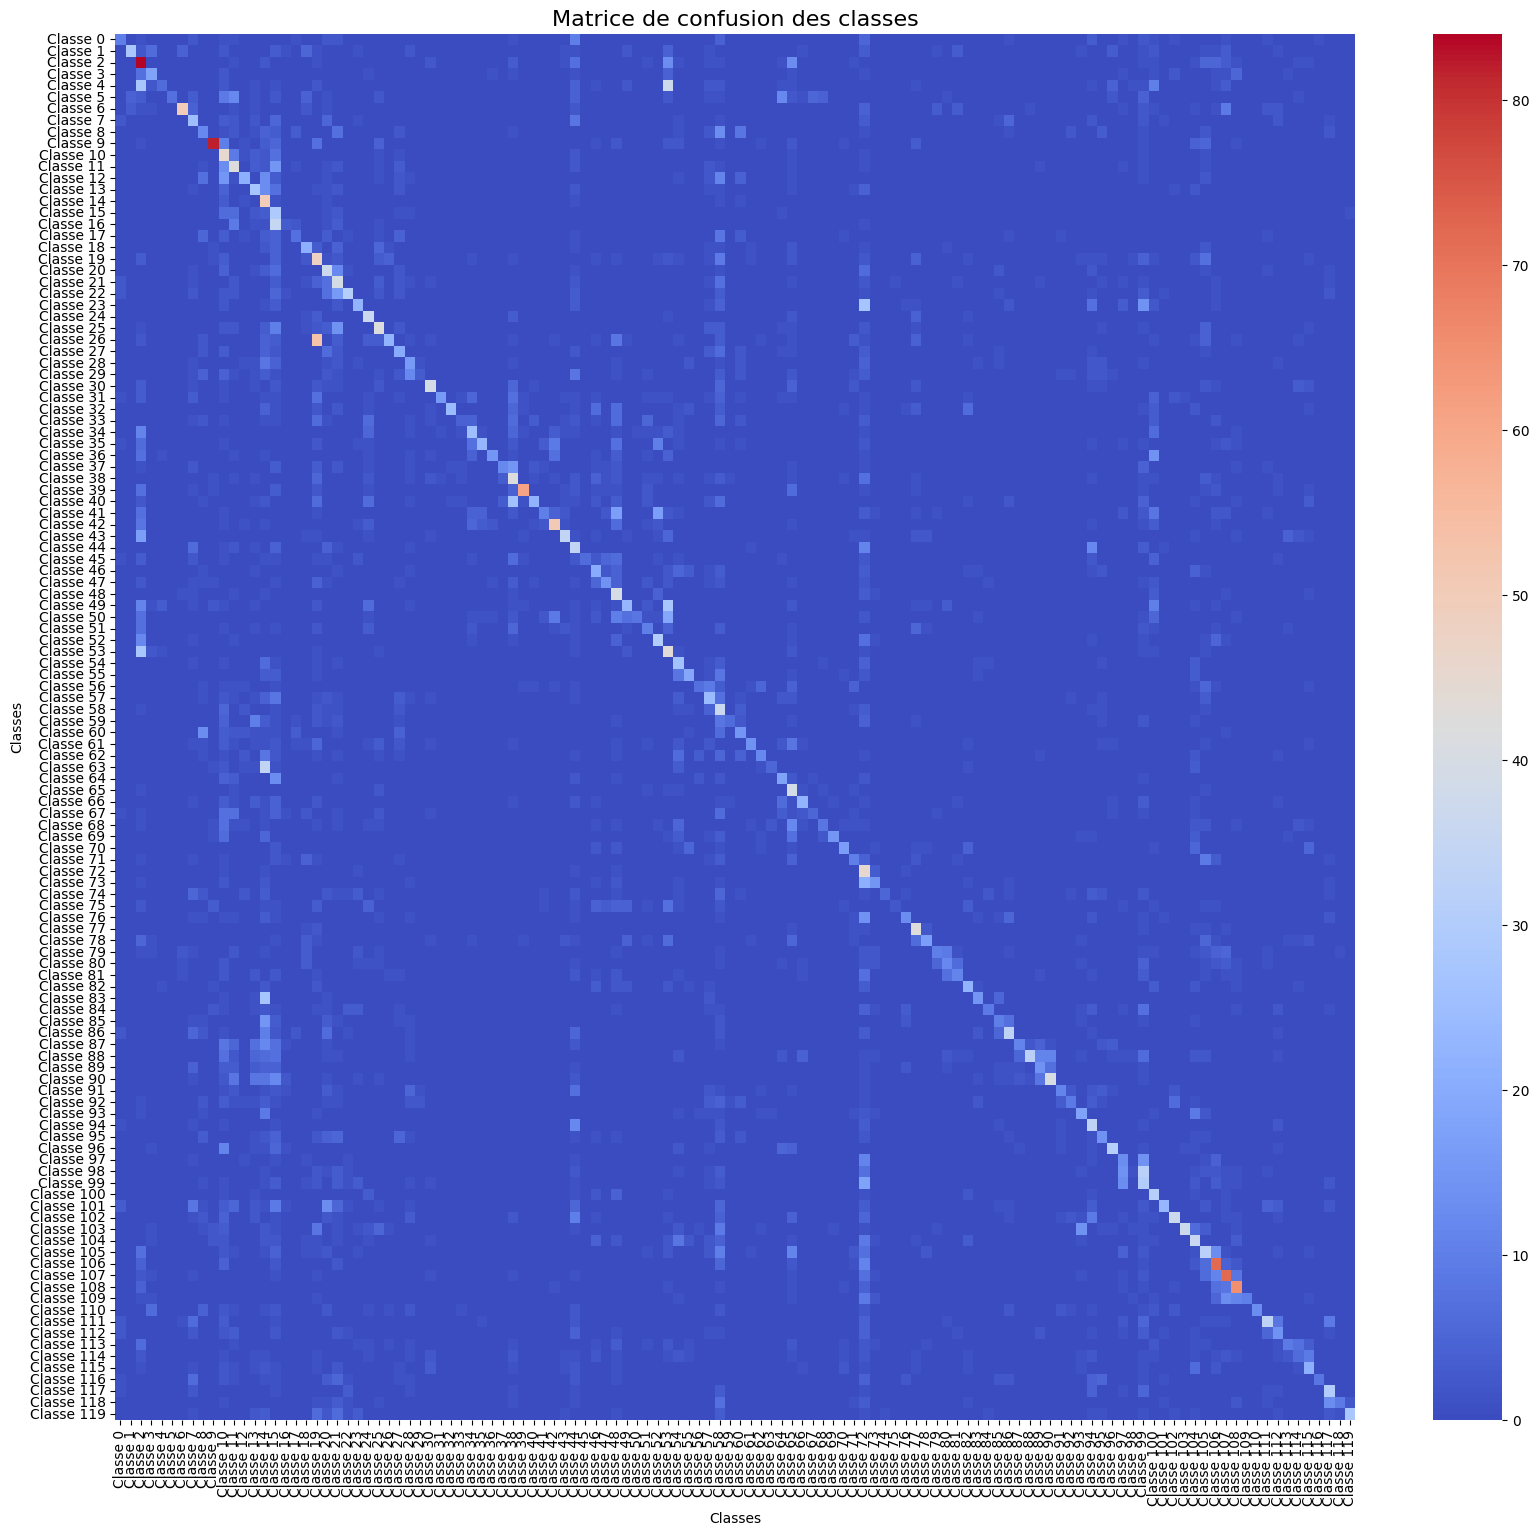

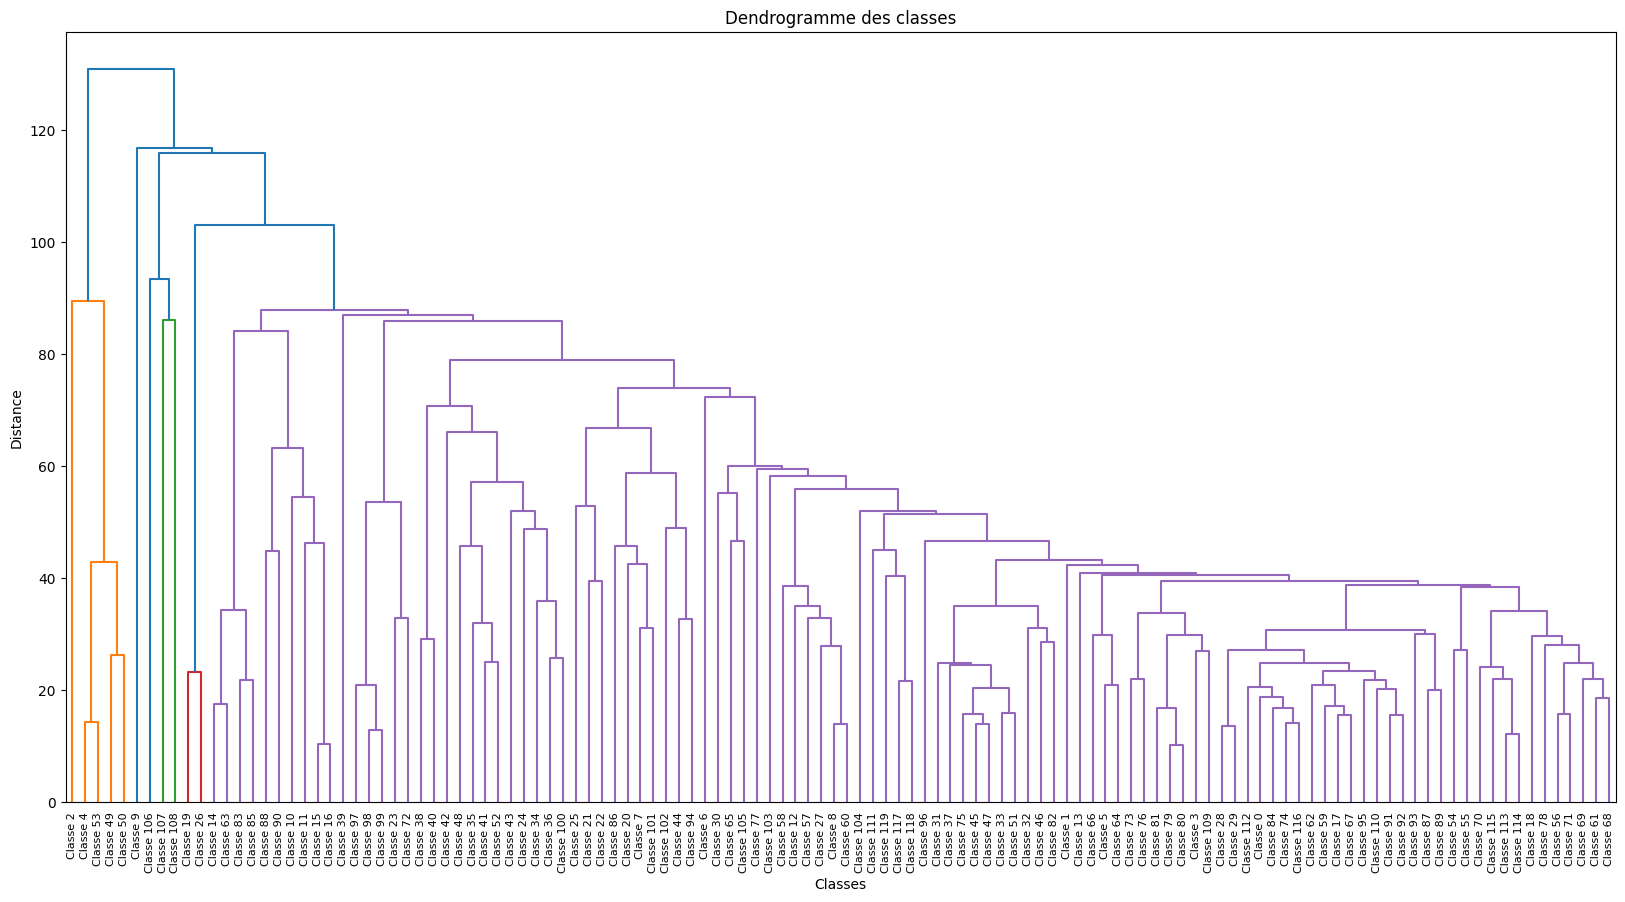

In [12]:
train_transfer_model(pretrained_model, train_loader, test_loader, criterion, optimizer, patience=5)

In [13]:
train_loader, test_loader, classes = load_dataloaders_and_classes("datasets_and_classes.pkl", "no_augment")

DataLoaders and classes for 'no_augment' loaded from datasets_and_classes.pkl


Epoch 1/1000, Loss: 1.0671
Epoch 1/1000, Validation Accuracy: 82.30%

Epoch 2/1000, Loss: 0.8781
Epoch 2/1000, Validation Accuracy: 82.20%

Early stopping déclenché à l'époque 2


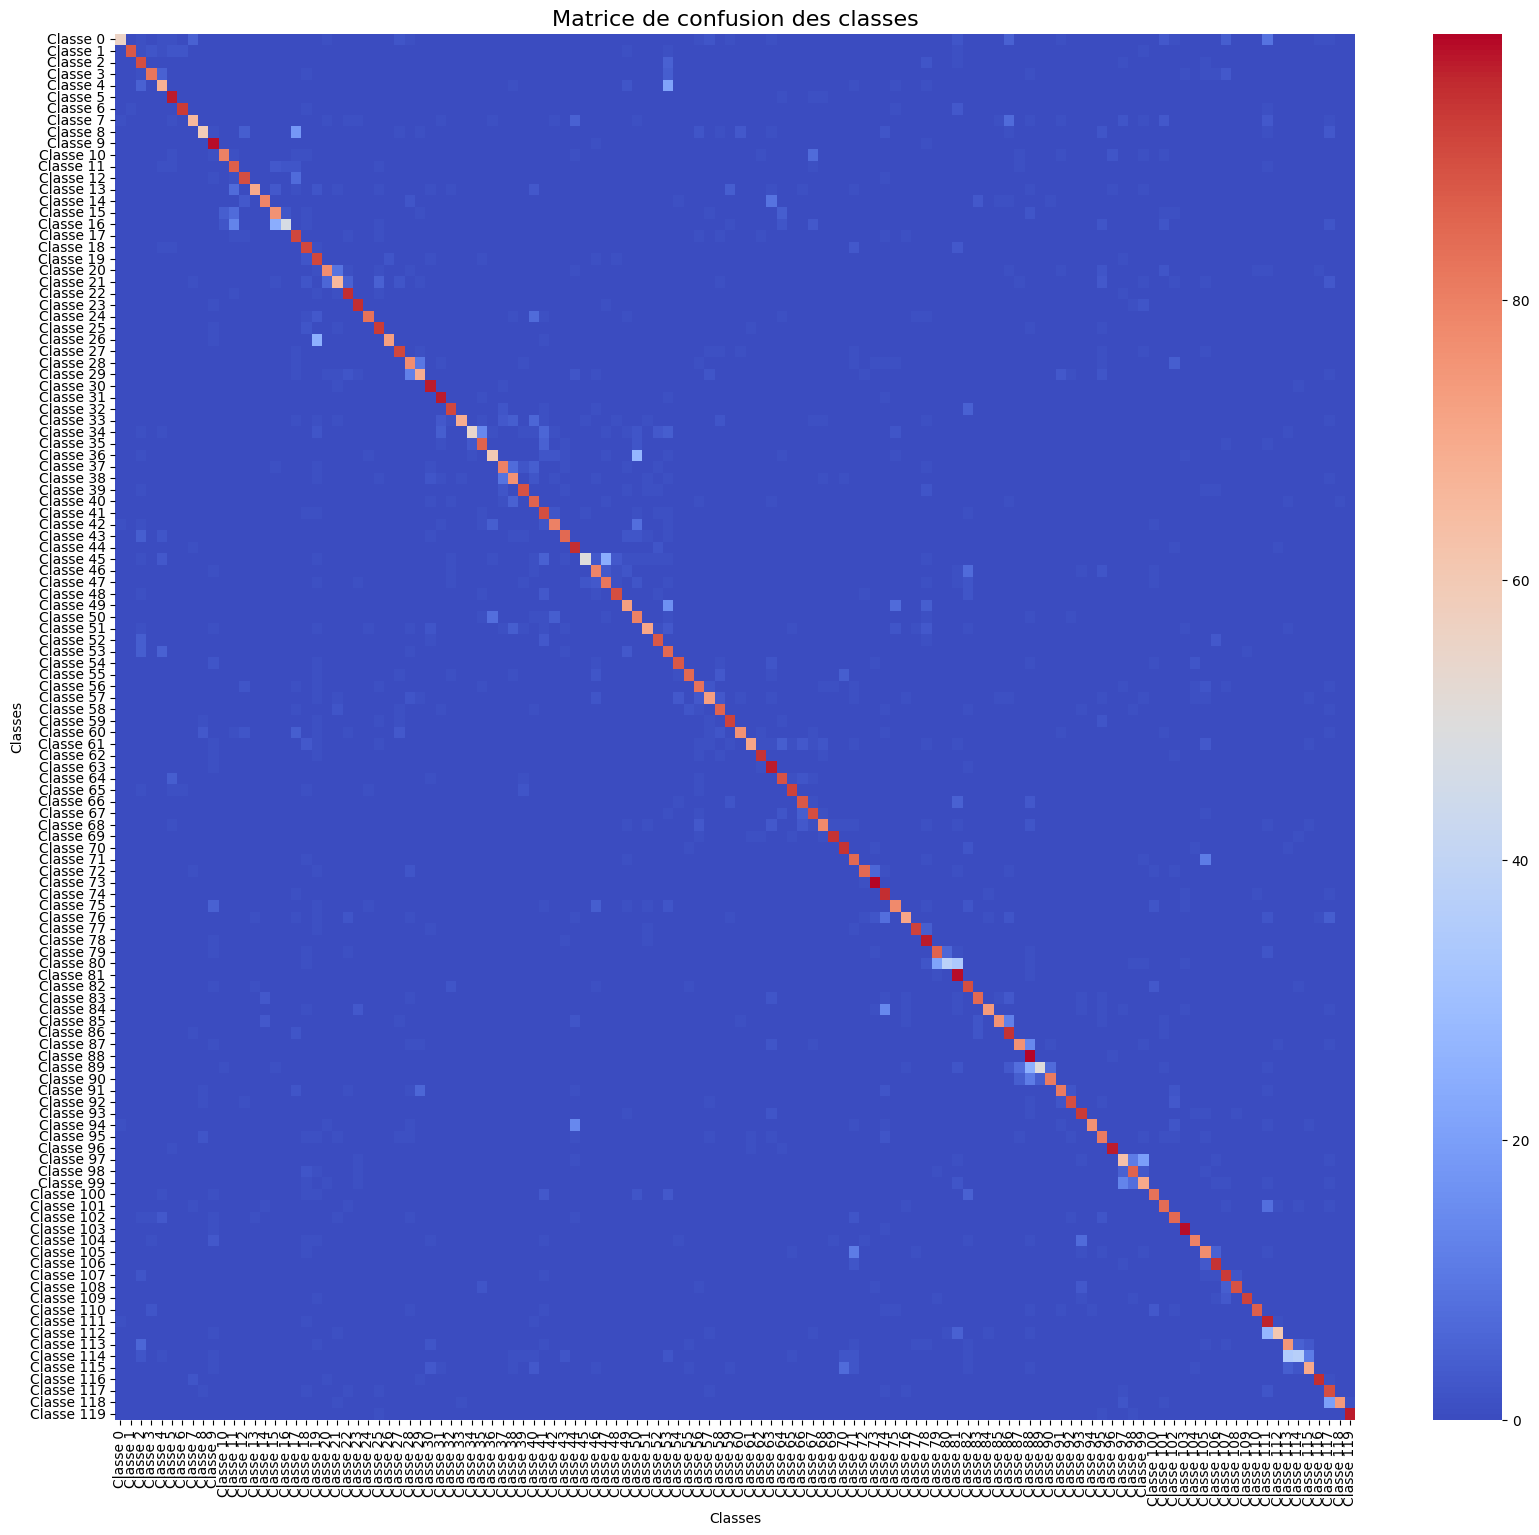

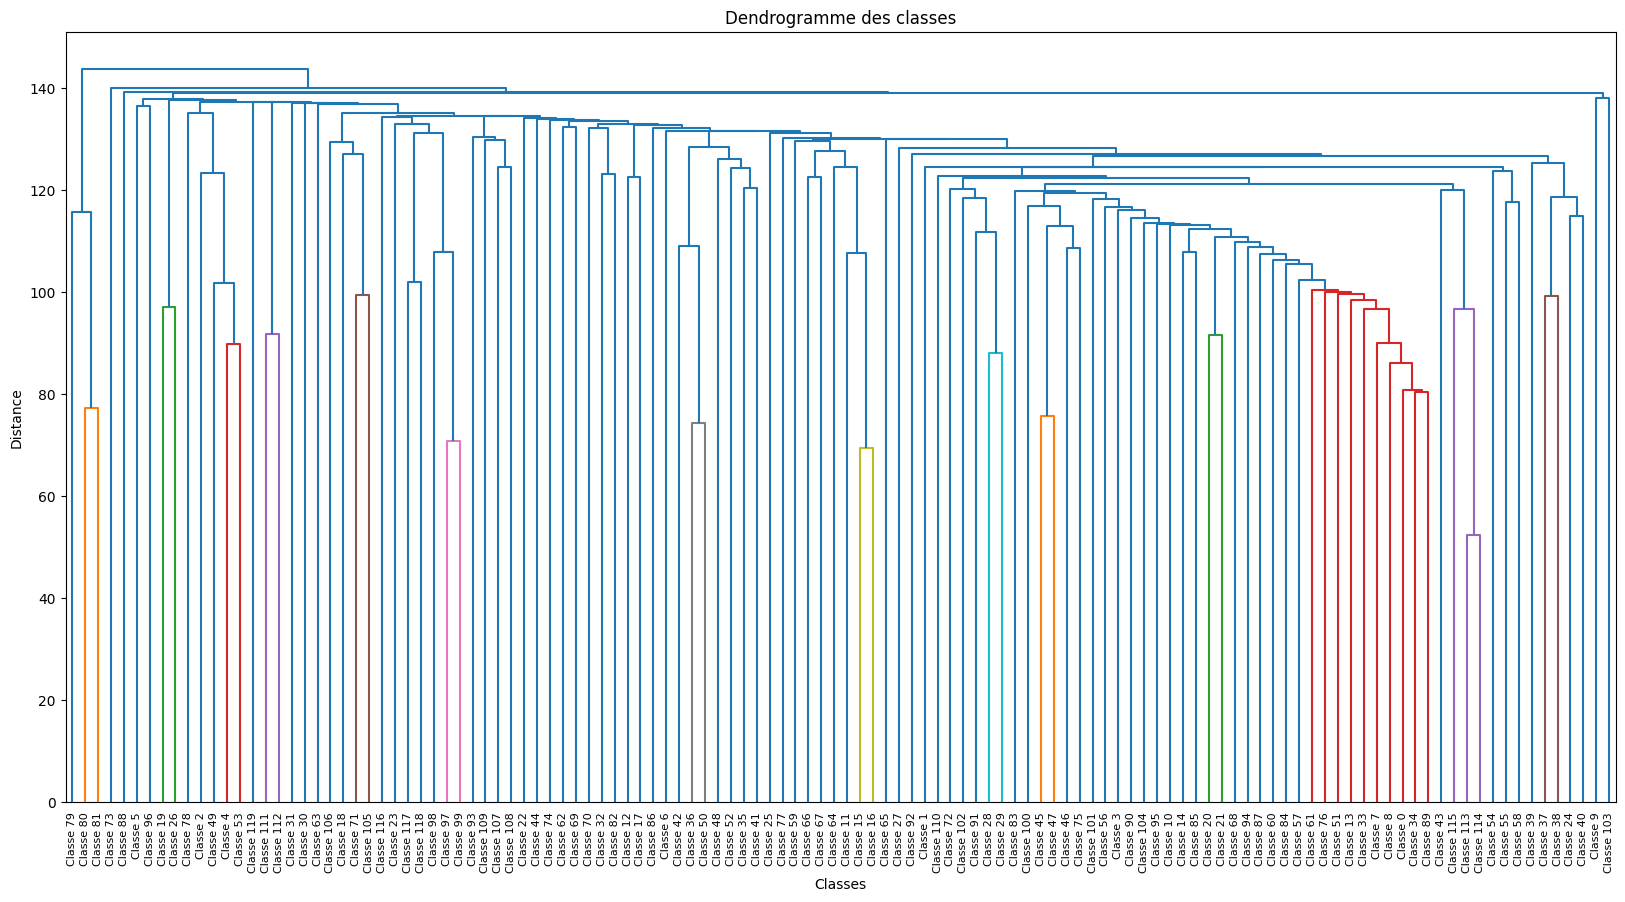

In [14]:
train_transfer_model(pretrained_model, train_loader, test_loader, criterion, optimizer, patience=1)

In [21]:
torch.save(pretrained_model.state_dict(), "resnet18_transfer.pth")

In [18]:
pretrained_model_no_aug = models.resnet18(pretrained=True)
for param in pretrained_model_no_aug.parameters():
    param.requires_grad = False
num_classes = len(classes)
pretrained_model_no_aug.fc = nn.Linear(pretrained_model_no_aug.fc.in_features, num_classes)

criterion_no_aug = nn.CrossEntropyLoss()
optimizer_no_aug = optim.Adam(pretrained_model_no_aug.parameters(), lr=0.001) 

c:\Users\milan\Documents\oc\.oc\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\milan\Documents\oc\.oc\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
train_loader, test_loader, classes = load_dataloaders_and_classes("datasets_and_classes.pkl", "no_augment")

DataLoaders and classes for 'no_augment' loaded from datasets_and_classes.pkl


Epoch 1/1000, Loss: 2.6685
Epoch 1/1000, Validation Accuracy: 60.48%

Epoch 2/1000, Loss: 1.2317
Epoch 2/1000, Validation Accuracy: 66.47%

Epoch 3/1000, Loss: 0.9294
Epoch 3/1000, Validation Accuracy: 68.92%

Epoch 4/1000, Loss: 0.7632
Epoch 4/1000, Validation Accuracy: 70.48%

Epoch 5/1000, Loss: 0.6644
Epoch 5/1000, Validation Accuracy: 70.86%

Epoch 6/1000, Loss: 0.6000
Epoch 6/1000, Validation Accuracy: 70.36%

Epoch 7/1000, Loss: 0.5276
Epoch 7/1000, Validation Accuracy: 70.50%

Epoch 8/1000, Loss: 0.4878
Epoch 8/1000, Validation Accuracy: 70.80%

Epoch 9/1000, Loss: 0.4397
Epoch 9/1000, Validation Accuracy: 71.76%

Epoch 10/1000, Loss: 0.4021
Epoch 10/1000, Validation Accuracy: 70.67%

Epoch 11/1000, Loss: 0.3766
Epoch 11/1000, Validation Accuracy: 71.15%

Epoch 12/1000, Loss: 0.3502
Epoch 12/1000, Validation Accuracy: 70.12%

Epoch 13/1000, Loss: 0.3240
Epoch 13/1000, Validation Accuracy: 70.30%

Epoch 14/1000, Loss: 0.2969
Epoch 14/1000, Validation Accuracy: 70.93%

Early stop

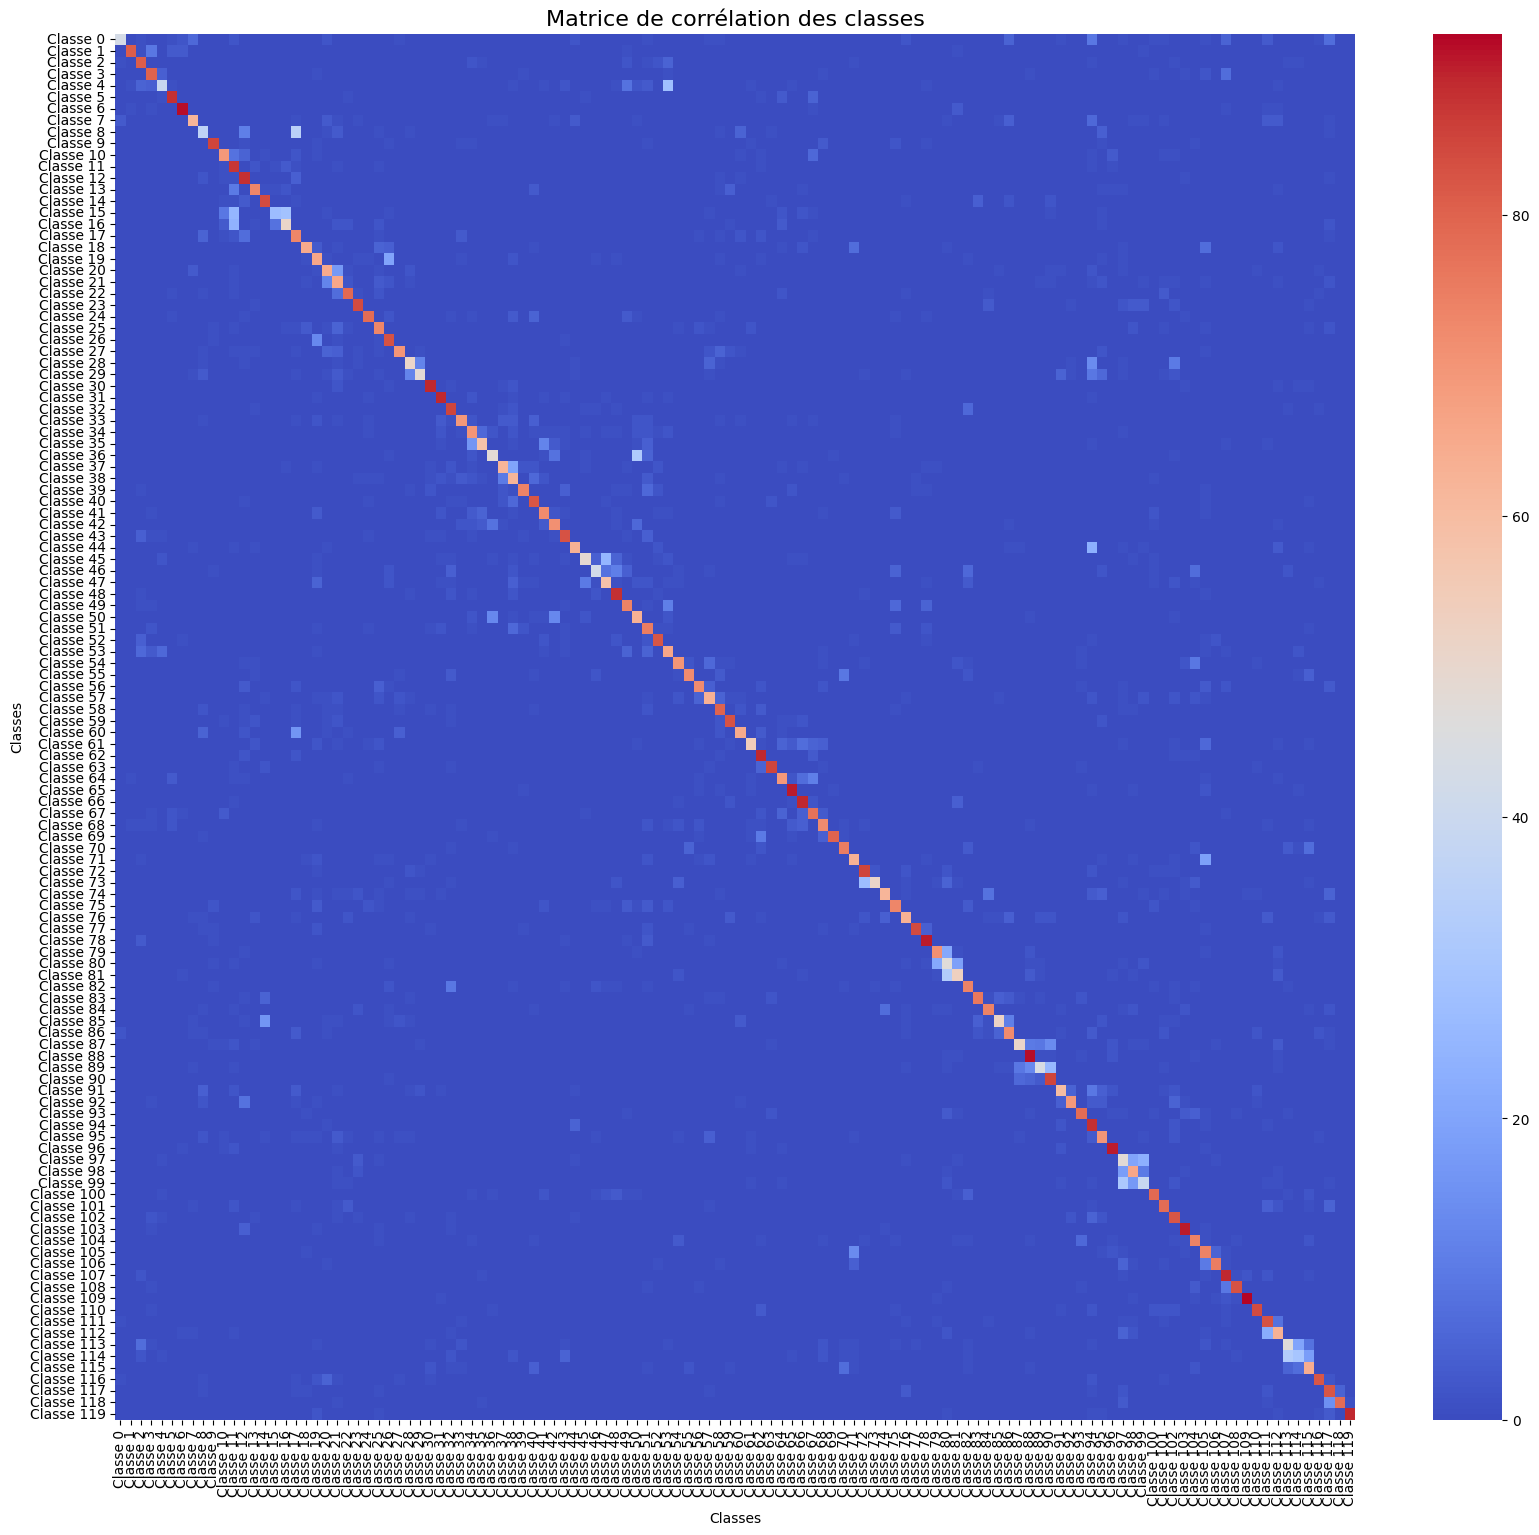

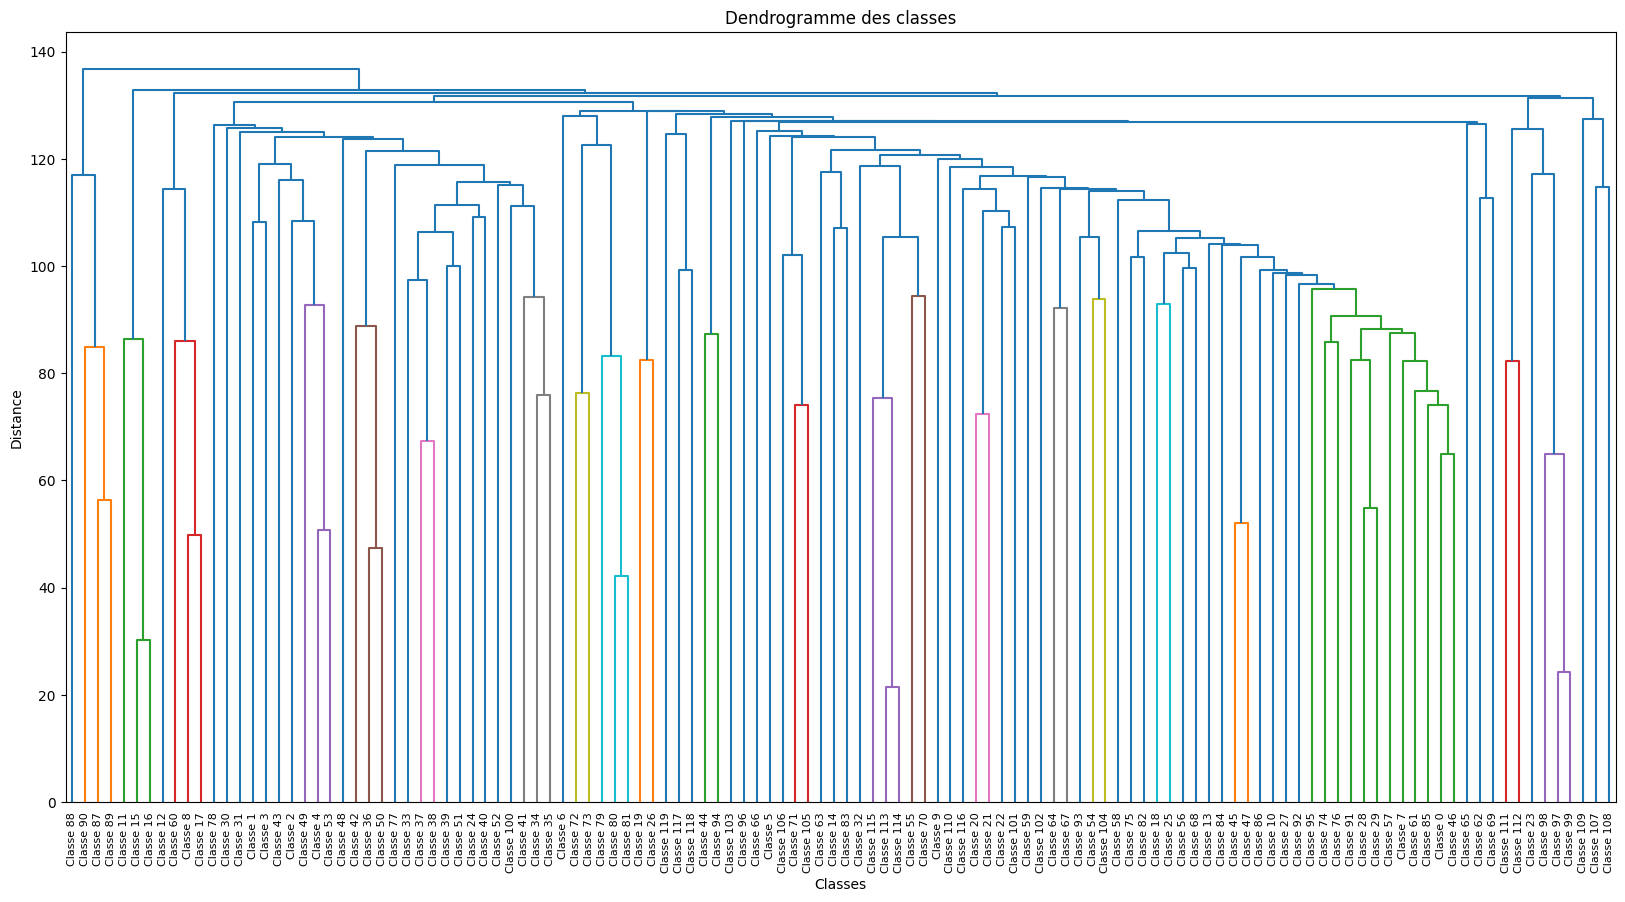

In [19]:
train_transfer_model(pretrained_model_no_aug, train_loader, test_loader, criterion_no_aug, optimizer_no_aug)

In [20]:
torch.save(pretrained_model_no_aug.state_dict(), "pretrained_model_no_aug.pth")

In [23]:
train_loader, test_loader, classes = load_dataloaders_and_classes("datasets_and_classes.pkl", "efficientnet")
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")

DataLoaders and classes for 'efficientnet' loaded from datasets_and_classes.pkl
Number of training samples: 12000
Number of testing samples: 8580


In [24]:
pretrained_model = models.efficientnet_b0(pretrained=True)
for param in pretrained_model.parameters():
    param.requires_grad = False
num_classes = len(classes)
pretrained_model.classifier[1] = nn.Linear(pretrained_model.classifier[1].in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

c:\Users\milan\Documents\oc\.oc\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\milan\Documents\oc\.oc\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 3.0835
Epoch 1/10, Validation Accuracy: 4.24%

Epoch 2/10, Loss: 1.8484
Epoch 2/10, Validation Accuracy: 5.94%

Epoch 3/10, Loss: 1.5106
Epoch 3/10, Validation Accuracy: 6.27%

Epoch 4/10, Loss: 1.3466
Epoch 4/10, Validation Accuracy: 4.99%

Epoch 5/10, Loss: 1.2389
Epoch 5/10, Validation Accuracy: 5.09%

Epoch 6/10, Loss: 1.1292
Epoch 6/10, Validation Accuracy: 6.11%

Epoch 7/10, Loss: 1.0693
Epoch 7/10, Validation Accuracy: 4.97%

Epoch 8/10, Loss: 1.0079
Epoch 8/10, Validation Accuracy: 5.40%

Early stopping déclenché à l'époque 8


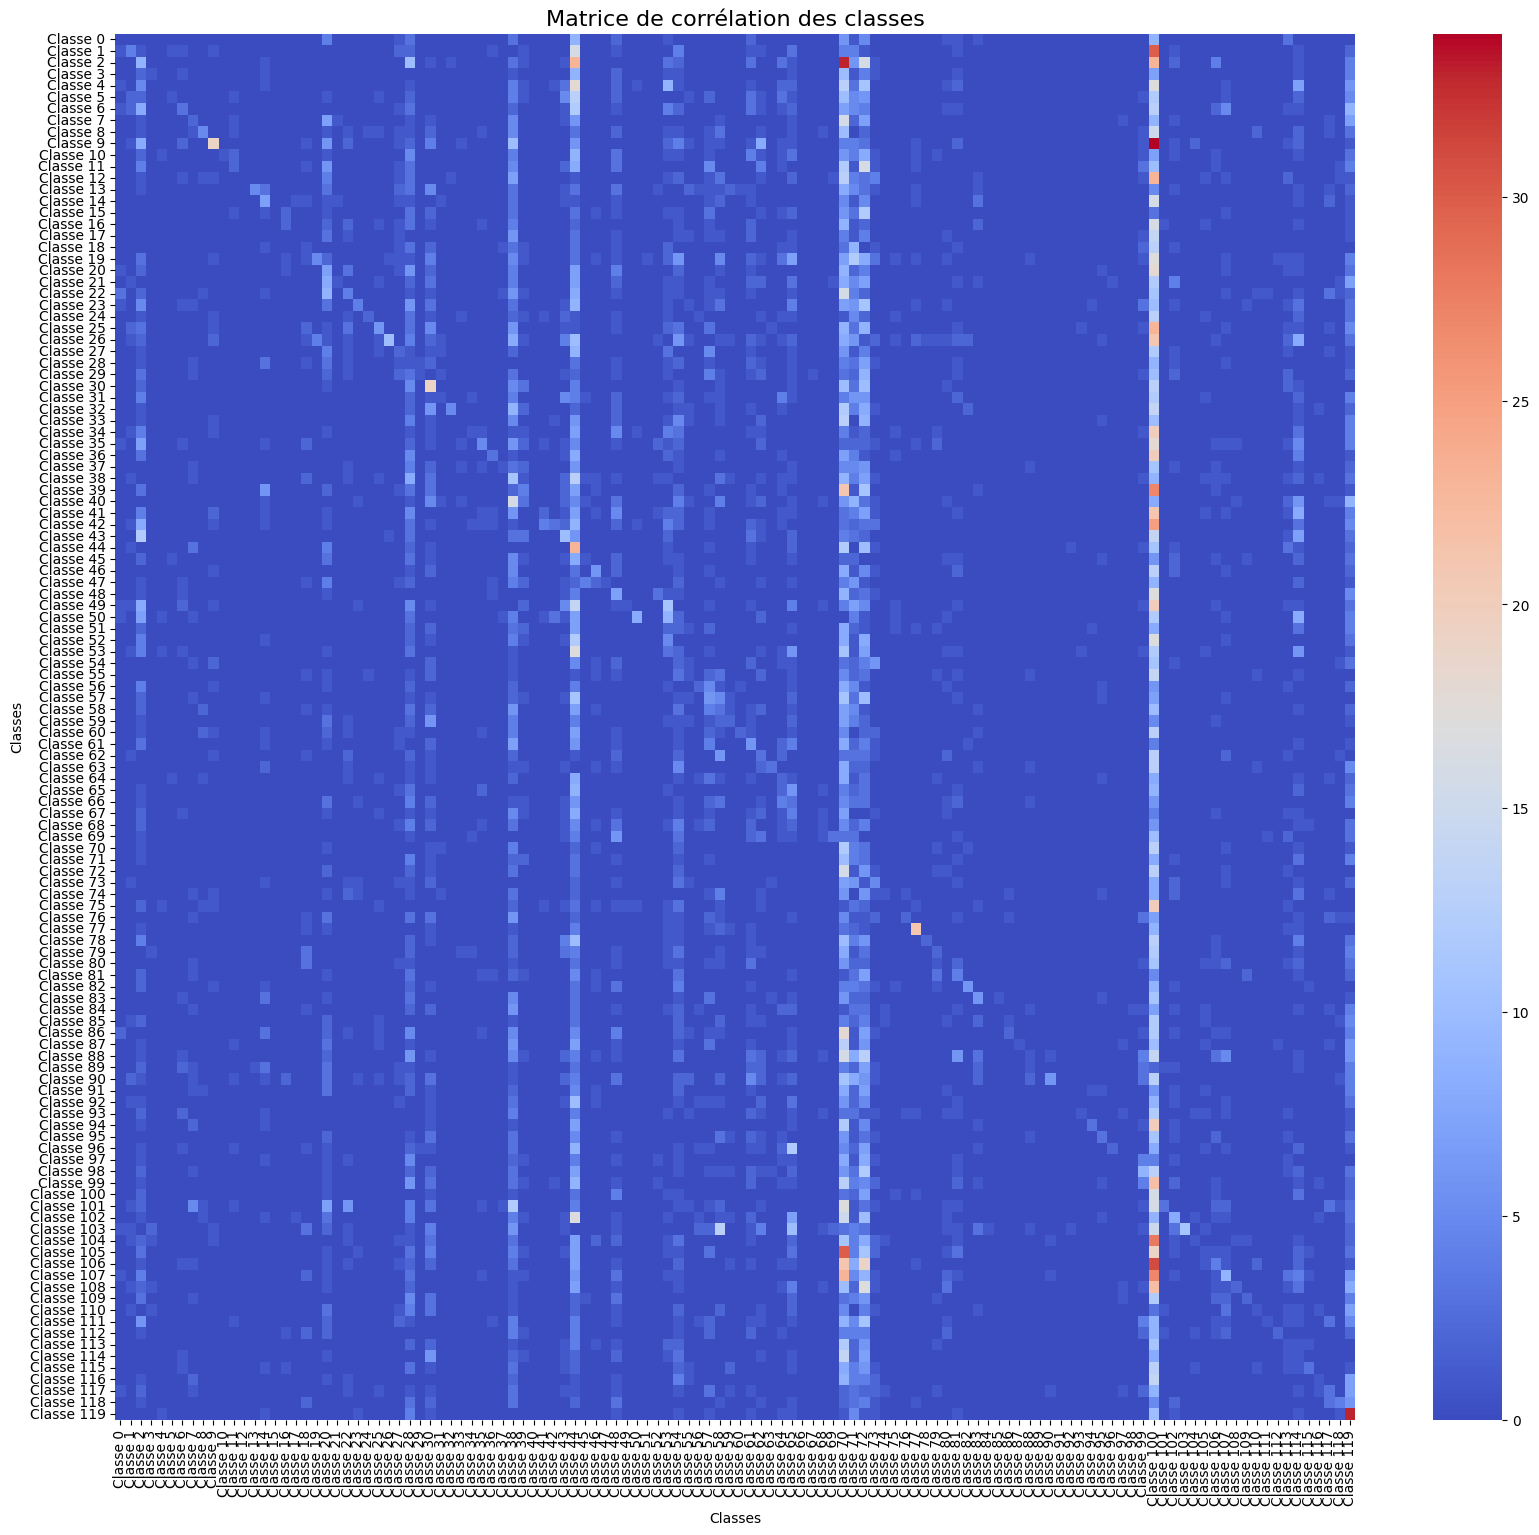

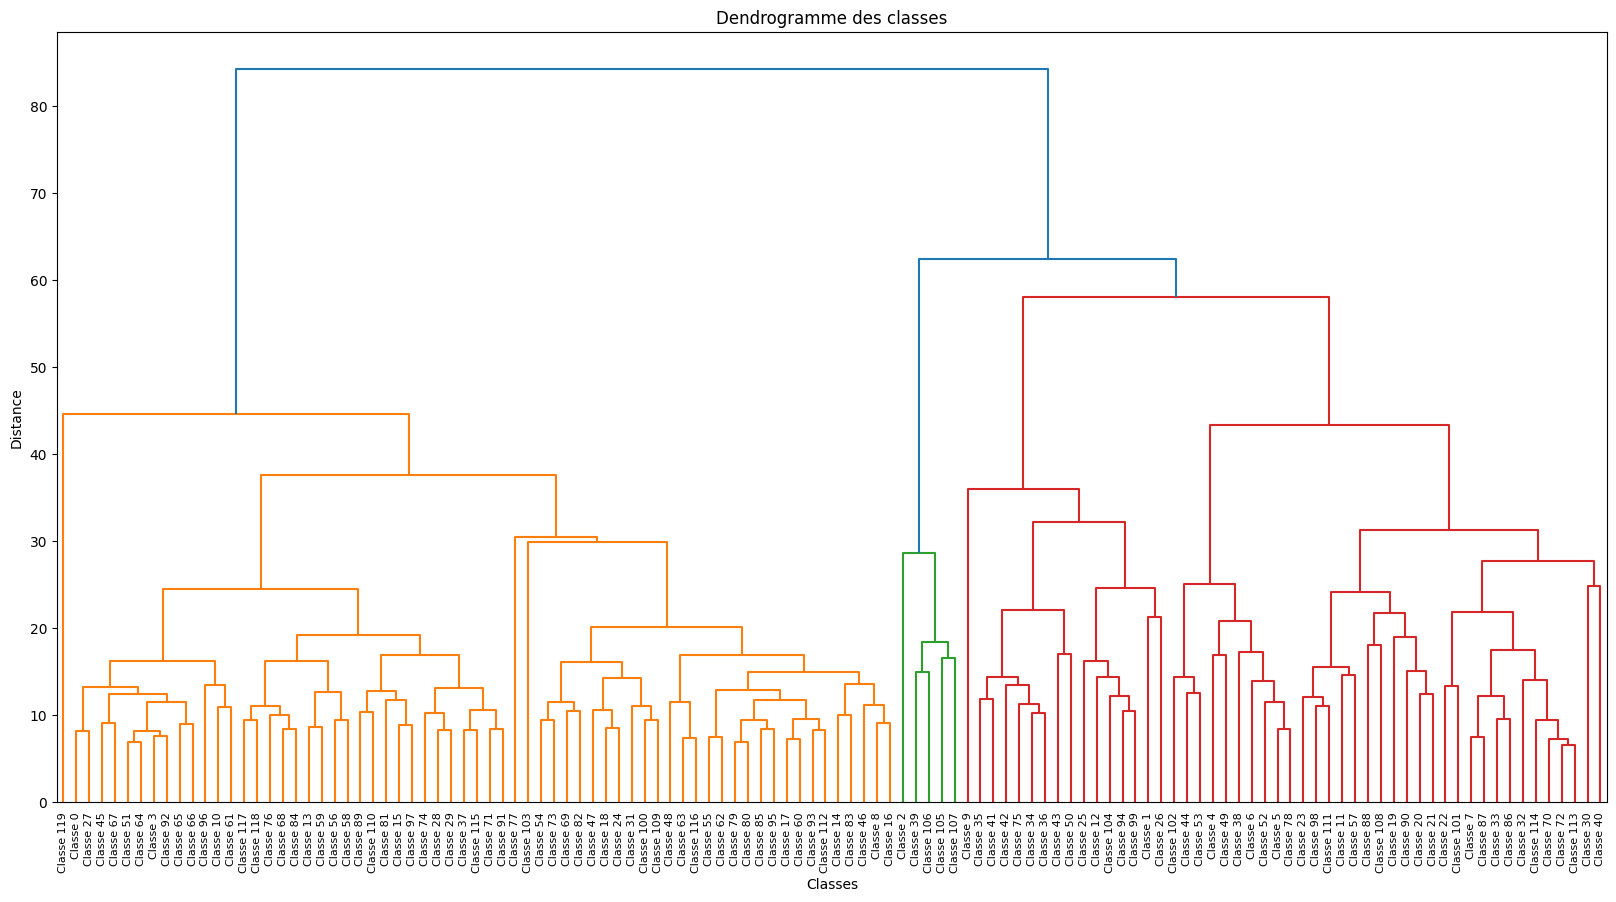

In [25]:
train_transfer_model(pretrained_model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

In [26]:
train_loader, test_loader, classes = load_dataloaders_and_classes("datasets_and_classes.pkl", "no_augment")

DataLoaders and classes for 'no_augment' loaded from datasets_and_classes.pkl


Epoch 1/10, Loss: 1.4228
Epoch 1/10, Validation Accuracy: 83.62%

Epoch 2/10, Loss: 1.1635
Epoch 2/10, Validation Accuracy: 82.12%

Epoch 3/10, Loss: 0.9903
Epoch 3/10, Validation Accuracy: 81.67%

Epoch 4/10, Loss: 0.8567
Epoch 4/10, Validation Accuracy: 80.48%

Epoch 5/10, Loss: 0.7816
Epoch 5/10, Validation Accuracy: 79.58%

Epoch 6/10, Loss: 0.7034
Epoch 6/10, Validation Accuracy: 79.02%

Early stopping déclenché à l'époque 6


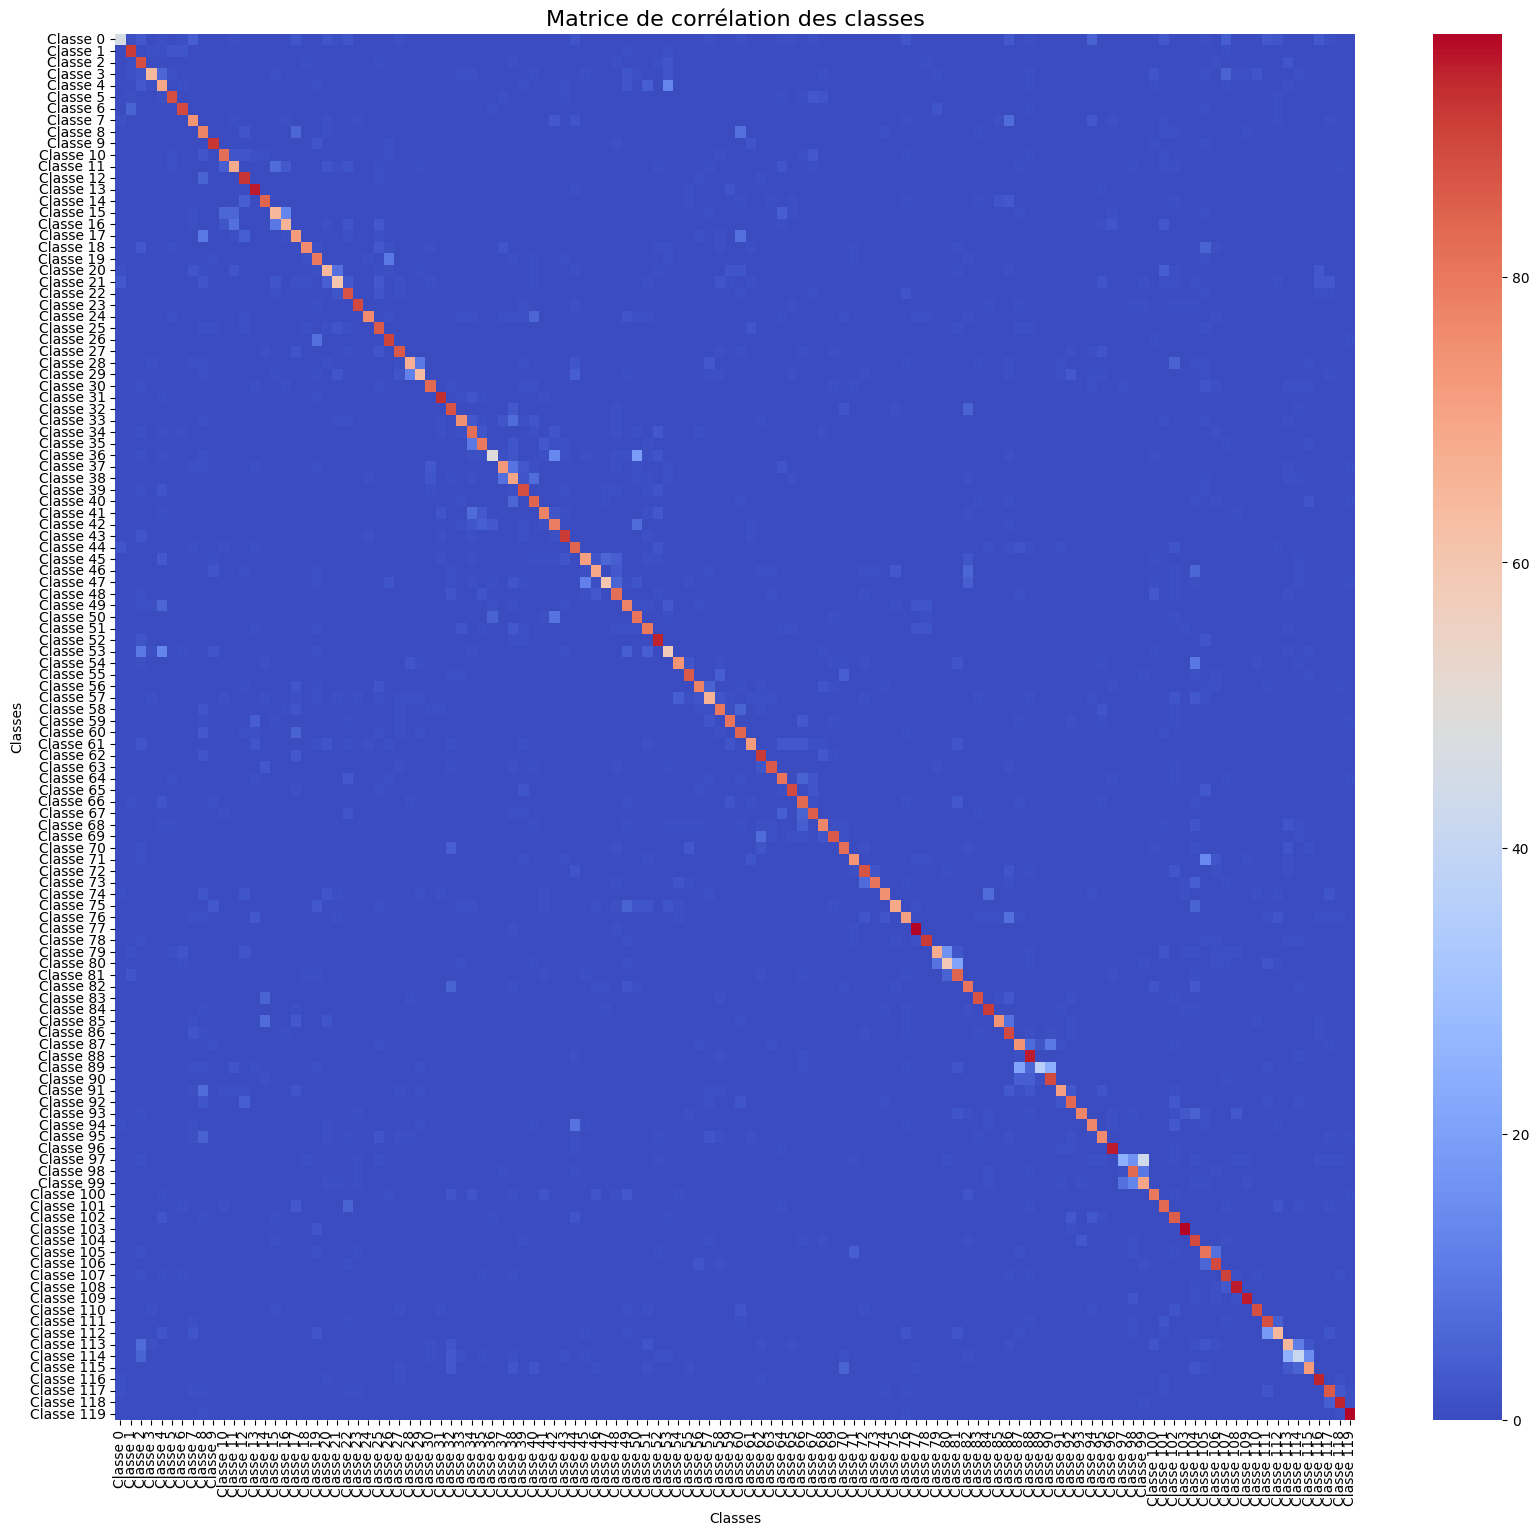

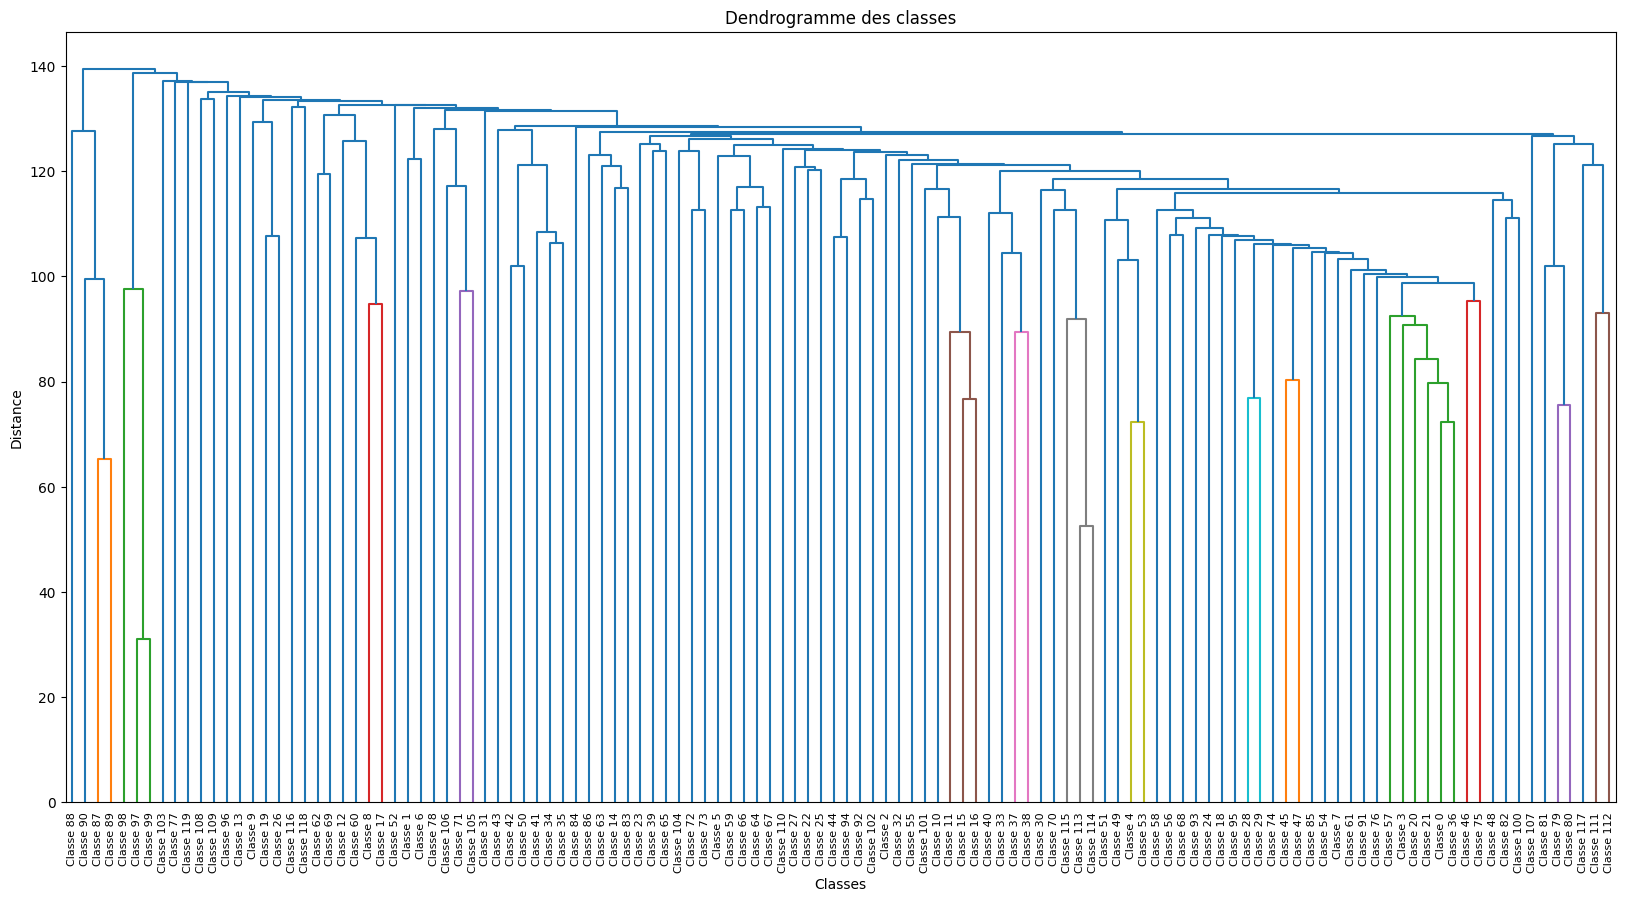

In [27]:
train_transfer_model(pretrained_model, train_loader, test_loader, criterion, optimizer, num_epochs=10)